# Cluster Spotify Songs

The data consist of 25 parameters from ~300k spotify songs.
These parameters include identifying information (e.g., artist, album, track_id) as well as various song-related features (e.g., 'danceability', 'energy', 'key').
We're going to explore different methods for clustering these songs.
Accurate clustering would allow a recommendation algorithm to suggest new songs



#### load modules

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

#### load data

In [2]:
data_path = '/Users/andrew/Documents/GitHub/data_science/song_clustering/data/'
df = pd.read_csv(data_path + 'tracks_features_subsample.csv')

In [44]:
df.columns

Index(['Unnamed: 0', 'id', 'name', 'album', 'album_id', 'artists',
       'artist_ids', 'track_number', 'disc_number', 'explicit', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature', 'year', 'release_date'],
      dtype='object')

#### Description of categories
(descriptions taken from Spotify's website)
Starting with the less-than-obvious columns.

danceability: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

energy: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

acousticness: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

instrumentalness: Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

loudness: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.

mode: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

speechiness: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

key: The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.

time_signature: An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4".

tempo: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

## Group tracks into genres

In [3]:
# start by pulling out all of the relevant columns
X_all = df[['explicit','danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','valence','tempo','duration_ms','time_signature','year']]

# further downselect to only the non-categorical features
X_cont = X_all[['danceability','energy','loudness','speechiness','acousticness','instrumentalness','valence','tempo','duration_ms','year']]

# normalize loudness, tempo, duration_ms, and year to be between 0-1 (like the other variables)
temp_list = ['tempo','duration_ms','year','loudness']
for ii in temp_list:
    d = X_cont[ii]
    X_cont.loc[:,[ii]] = (d - np.min(d)) / (np.max(d) - np.min(d))

/Users/andrew/miniconda3/envs/jobPrep/lib/python3.11/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


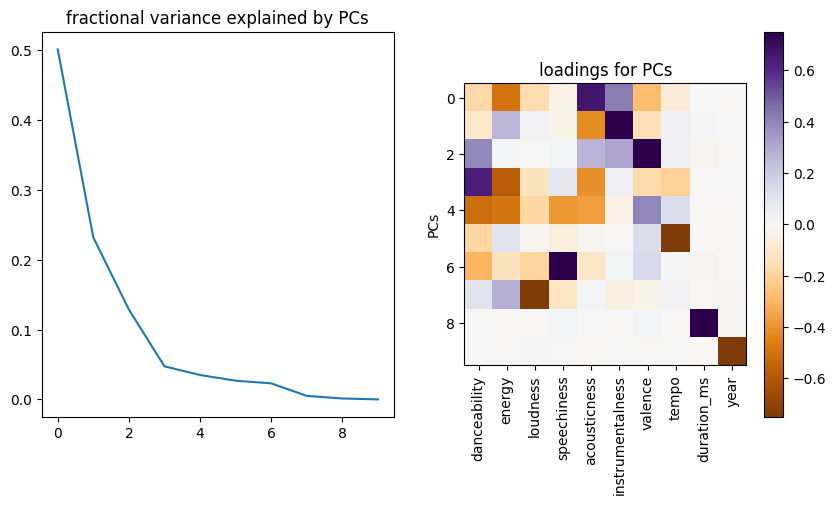

In [4]:
# run PCA on the continuous variables
from sklearn.decomposition import PCA

# convert to array
X_cont_array = np.array(X_cont)

# fit model
pca = PCA(n_components = None)
proj = pca.fit_transform(X_cont_array);

# pull out weights
W = pca.components_

# pull out the explained variance (fraction of total variance)
varExp = pca.explained_variance_ratio_

# plot variance explained
plt.figure(figsize=(10,5))
plt.subplot(121);
plt.plot(varExp);
plt.title('fractional variance explained by PCs');

# plot the loadings for the PCs
plt.subplot(122);
plt.imshow(W, cmap='PuOr');
plt.colorbar();
plt.ylabel('PCs');
plt.clim([-0.75, 0.75]);
plt.xticks(np.arange(proj.shape[1]), labels = X_cont.columns, rotation=90);
plt.title('loadings for PCs');



### duration and year aren't doing us any good (PCs 9 and 10 are just duration and year), so toss these and re-run PCA

/Users/andrew/miniconda3/envs/jobPrep/lib/python3.11/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


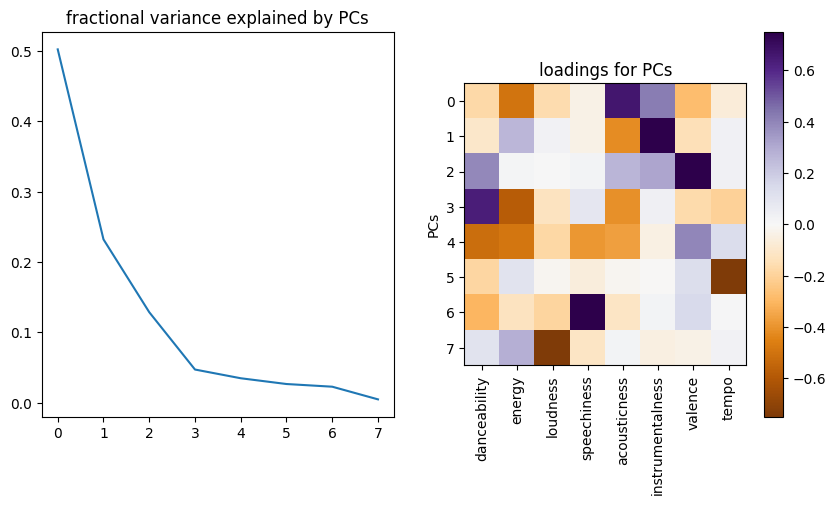

In [5]:
# drop duration and year
X_cont.drop(['duration_ms','year'],axis=1, inplace=True)

# convert to array
X_cont_array = np.array(X_cont)

# fit model
pca = PCA(n_components = None)
proj = pca.fit_transform(X_cont_array);

# pull out weights
W = pca.components_

# pull out the explained variance (fraction of total variance)
varExp = pca.explained_variance_ratio_

# plot variance explained
plt.figure(figsize=(10,5))
plt.subplot(121);
plt.plot(varExp);
plt.title('fractional variance explained by PCs');

# plot the loadings for the PCs
plt.subplot(122);
plt.imshow(W, cmap='PuOr');
plt.colorbar();
plt.ylabel('PCs');
plt.clim([-0.75, 0.75]);
plt.xticks(np.arange(proj.shape[1]), labels = X_cont.columns, rotation=90);
plt.title('loadings for PCs');

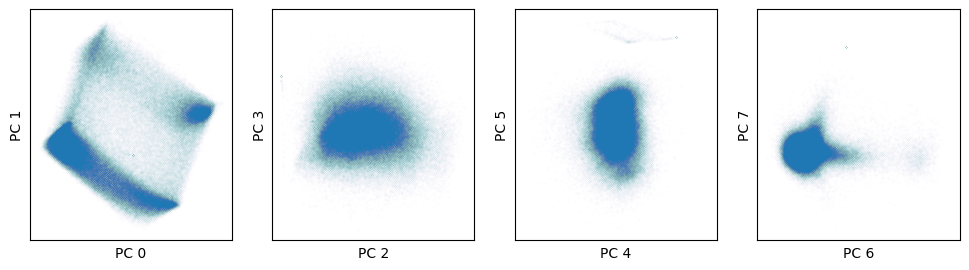

In [6]:
# plot the songs in a few different spaces
plt.figure(figsize=(12,3));
spaces_to_plot = np.arange(8).reshape(-1,2,order='C');
for ii in range(4):
    ax = plt.subplot(1,4,ii+1);
    plt.plot(proj[:,spaces_to_plot[ii,0]],proj[:,spaces_to_plot[ii,1]], '.', ms=0.01);
    plt.xlabel('PC ' + str(spaces_to_plot[ii,0]))
    plt.ylabel('PC ' + str(spaces_to_plot[ii,1]))
    ax.set_xticks([]);
    ax.set_yticks([]);

#### As a baseline, cluster songs using K-means
using minibatches to speed things up

In [68]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

# range of clusters to try
clusters = np.arange(3,40,2)

# list to hold trained models
models_kMeans = []

# list to hold cluster ids
cluster_labels_kMeans = []

# average silhouette scores
sil_score = []

# to speed things up, only keep every 100th song
proj_ds = proj[::100,:]

# cycle through number of clusters
numClusters = []
for ii in clusters:

    print('number of clusters: ' + str(ii))

    # fit kMeans using a subset of the datat
    kmeans = MiniBatchKMeans(n_clusters=ii, n_init='auto', batch_size=3072).fit(proj_ds)
    models_kMeans.append(kmeans)

    # pull out cluster labels
    cluster_labels_kMeans.append(kmeans.labels_)

    # compute silhouette score
    sil_score.append(silhouette_score(proj_ds, kmeans.labels_))

    numClusters.append(ii)
numClusters = np.array(numClusters)

number of clusters: 3
number of clusters: 5
number of clusters: 7
number of clusters: 9
number of clusters: 11
number of clusters: 13
number of clusters: 15
number of clusters: 17
number of clusters: 19
number of clusters: 21
number of clusters: 23
number of clusters: 25
number of clusters: 27
number of clusters: 29
number of clusters: 31
number of clusters: 33
number of clusters: 35
number of clusters: 37
number of clusters: 39


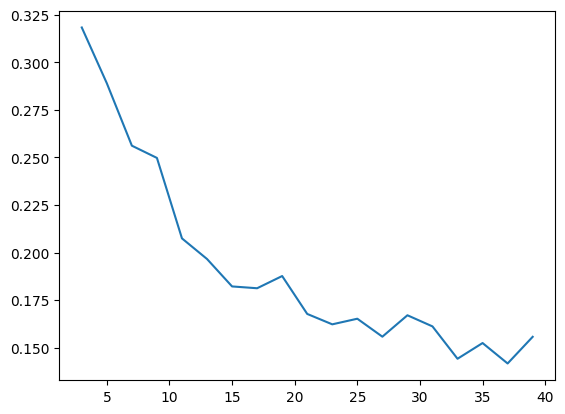

In [8]:
# plot the average silhouette score for each number of clusters
plt.plot(clusters, sil_score);

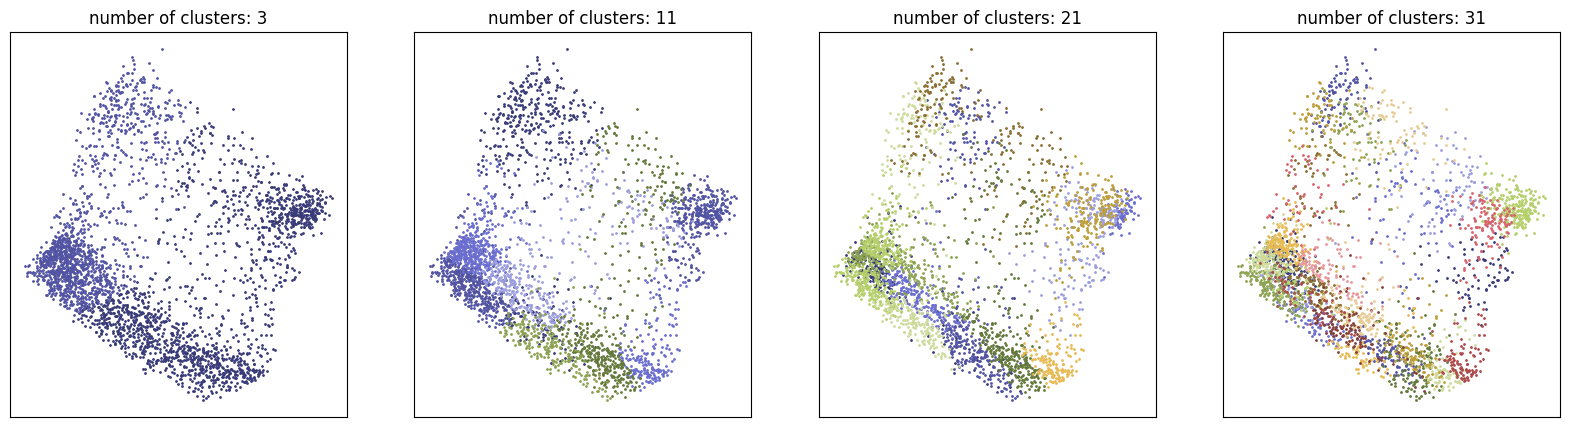

In [43]:
# plot the data in the top 2 PCs, colored by label
import matplotlib
cmap = matplotlib.colormaps['tab20b']
norm = matplotlib.colors.Normalize(vmin=0, vmax=clusters[-1]);

plt.figure(figsize=(20,5))
for ii,jj in enumerate([3,11,21,31]):
    ax = plt.subplot(1,4,ii+1);
    lIdx = np.nonzero(numClusters==jj)[0][0]

    for kk in range(jj):
        idx = cluster_labels_kMeans[lIdx] == kk
        plt.plot(proj_ds[idx,0],proj_ds[idx,1],'.', ms = 2, color=cmap(norm(kk)))

    # add a title
    plt.title('number of clusters: ' + str(jj));

    # remove tick labels
    ax.set_xticks([]);
    ax.set_yticks([]);

#### Ideally, we'd have ground-truth labels that we could use to cross-validate the number of clusters
absent these labels, we can use heuristics that are likely to be closely correlated with genre
The first heuristic simply asks how frequently songs from the same artist (or the same album), is split between 2 clusters (which is likely to reflect over-splitting)


In [63]:
def oversplit_heuristic(artist_ids, album_ids, album_weight, model, projection):

    """
    :param artist_ids: unique string identifier
    :param album_ids: unique string identifier
    :param album_weight: how much to weight album relative to artists (albums are less likely to have songs from different genres than a single artist is to make music that fits into different genres)
    :param model: fit kMeans model
    :param projection: N x K matrix of songs projected into PC space
    :return: splitting_score: scalar that reflects how 'over split' a single clustering is. A higher number indicates worse over splitting
    """

    # run through all of the artists, find the number of unique clusters
    u_artists = np.unique(artist_ids)
    num_artists = len(u_artists)
    artist_score = np.zeros(num_artists)
    for ii in range(num_artists):
        artist_score[ii] = len(np.unique(model.predict(projection[artist_ids == u_artists[ii]])))

    # do the same for the albums
    u_albums = np.unique(album_ids)
    num_albums = len(u_albums)
    album_score = np.zeros(num_albums)
    for ii in range(num_albums):
        album_score[ii] = len(np.unique(model.predict(projection[album_ids == u_albums[ii]])))

    # calculate final score and return scalar
    return np.sum(artist_score) + (np.sum(album_score)) * album_weight

#### Cycle through models, calculate heuristic for subset of songs

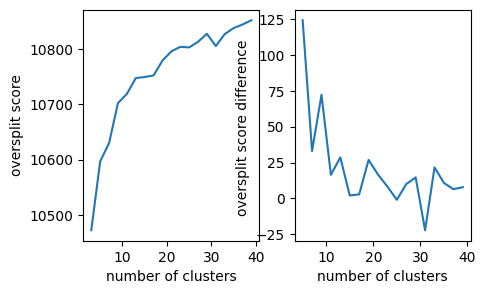

In [75]:
# pull out the albums and artist ids
albums = np.array(df['album_id'])
artist = np.array(df['artist_ids'])

# number of songs to test
num_test_songs = 5000

# list to hold results
oversplit_scores = []
for ii in models_kMeans:
    oversplit_scores.append(oversplit_heuristic(artist[:num_test_songs], albums[:num_test_songs], 1.2, ii, proj[:num_test_songs,:]))

# plot results
plt.figure(figsize=(5,3));
plt.subplot(121);
plt.plot(clusters, oversplit_scores)
plt.xlabel('number of clusters')
plt.ylabel('oversplit score')

plt.subplot(122);
plt.plot(clusters[1:], np.diff(oversplit_scores))
plt.xlabel('number of clusters')
plt.ylabel('oversplit score difference ');


#### from the above, it looks like choosing n=15 for the clusters is reasonable
as a sanity check, lets list a few songs that were placed in the same cluster


In [100]:
# the index for the model that was trained with 15 clusters
model_idx = np.nonzero(clusters == 15)[0][0]

# pull out the songs (and albums and artists) that were used to fit this model
train_data = df[['name','album','artists']][::100]

# add the cluster id as a column
train_data['cluster_id'] = cluster_labels_kMeans[model_idx]

# print a subset of songs belonging to a single cluster
num_songs = 10
x = train_data.loc[train_data['cluster_id'] == cluster_idx,:]
print(x.head(n=num_songs))

                                name                          album  \
0                         Delete You                       Bmin / E   
200        Living Loving Maid (Live)       The Essential Collection   
500    Booty Killah (feat. The Reef)          Look Like You Love It   
3800                D'Agostino, Gigi                    Tecno Fes 2   
6300                   Blue on Black  And Justice for None (Deluxe)   
7900                   Unlucky Break                    B and Not B   
10000             Letters Never Sent             Letters Never Sent   
12700               Pop Icon Puppets        Trials and Tribulations   
13000                Say Those Words              The Whole Shebang   
13800           Капли крови на губах                     12 Стульев   

                               artists  cluster_id  
0                         ['All Caps']           6  
200                    ['Great White']           6  
500          ['Elliphant', 'The Reef']           6  
3800  

#### from some initial exploration, the clustering seems ok
for example, there's lots of classical music in cluster 7 and pop in cluster 6